In [1]:
# imports
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import econml
import seaborn as sns
from IPython.display import Image, display
import graphviz

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

from causalnex.structure import StructureModel
import networkx as nx
from cdt.causality.graph import PC
from causalnex.network import BayesianNetwork
import cdt

from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
# data set loading
dataset = pd.read_csv('hotel_bookings.csv')
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
# data cleaning and transformation and feature engineering. 

# deposit_type to deposit or not
dataset['deposit_type']=dataset['deposit_type'].replace('No Deposit',False)
dataset['deposit_type']=dataset['deposit_type'].replace('Non Refund',True)
dataset['deposit_type']=dataset['deposit_type'].replace('Refundable',True)
dataset.columns = dataset.columns.str.replace('deposit_type', 'deposit')

# total stay 
dataset['total_stay'] = dataset['stays_in_week_nights']+dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices =dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned']=1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)

In [4]:
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries 

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
booking_changes                        0
deposit                                0
agent                              16340
company                           112593
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status                     0
reservation_stat

In [5]:
# agent, company columns has a lot of missing values. So, dropping those features. 
dataset = dataset.drop(['agent','company'],axis=1)

In [6]:
# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

In [7]:
# reservation_status and is_canceled features are same. 
# is_canceled[1] == reservation_status[canceled + no-show]
# so removing the reservation_status feature from the dataset
print (dataset['reservation_status'].value_counts())
print ("---")
print (dataset['is_canceled'].value_counts())
dataset = dataset.drop(['reservation_status'], axis=1)
print ("[reservation_status] feature dropped")

Check-Out    75166
Canceled     43017
No-Show       1207
Name: reservation_status, dtype: int64
---
0    75166
1    44224
Name: is_canceled, dtype: int64
[reservation_status] feature dropped


In [8]:
# lead_time is more useful feature for this project than "reservation_status_date". So removing that feature. 
dataset = dataset.drop(['reservation_status_date'], axis=1)

# dropping features which are less relevant from causal analysis point of view. 
dataset = dataset.drop(['arrival_date_day_of_month', 'arrival_date_year'], axis=1)

In [9]:
print (dataset.isnull().sum())
# very few records are missing. So dropping those records.
dataset = dataset.dropna()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_month                0
arrival_date_week_number          0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
booking_changes                   0
deposit                           0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
total_stay                        0
guests                            4
different_room_assigned           0
dtype: int64


In [10]:
# Replacing 1 by True and 0 by False for the experiment and outcome variables
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
dataset['is_canceled']= dataset['is_canceled'].replace(1,True)
dataset['is_canceled']= dataset['is_canceled'].replace(0,False)

In [11]:
# dropping features which are less relevant from causal analysis point of view. 
dataset = dataset.drop(['hotel', 'arrival_date_week_number', 'meal'], axis=1)

In [12]:
# converting the months to seasons
season_map = {'January':'Winter', 'February':'Winter', 'March':'Spring', 'April':'Spring', 'May':'Spring'
              , 'June':"Summer", 'July':'Summer', 'August':'Summer', 'September':'Fall', 'October':'Fall'
              , 'November':'Fall', 'December':'Winter'}
dataset['arrival_season'] = dataset['arrival_date_month'].map(season_map)
dataset = dataset.drop(['arrival_date_month'], axis=1)

In [13]:
# summer, spring hotel bookings are higher than rest. 
dataset["arrival_season"].value_counts()/len(dataset)*100

Summer    31.388102
Spring    27.368368
Fall      23.840316
Winter    17.403213
Name: arrival_season, dtype: float64

In [14]:
# todo: country, market_segment, distribution_channel  feature
print (len(dataset['country'].unique()))
print (dataset['market_segment'].value_counts())
print (dataset['distribution_channel'].value_counts())

177
Online TA        56476
Offline TA/TO    24219
Groups           19811
Direct           12605
Corporate         5295
Complementary      743
Aviation           237
Name: market_segment, dtype: int64
TA/TO        97870
Direct       14645
Corporate     6677
GDS            193
Undefined        1
Name: distribution_channel, dtype: int64


In [15]:
# dropping features which are less relevant from causal analysis point of view. 
dataset = dataset.drop(['country', 'market_segment', 'distribution_channel'], axis=1)

In [16]:
def map_prev_cancellations(x):
    if (x<10):
        return "low"
    elif (x>=10 and x<16):
        return "medium"
    else:
        return 'high'

In [17]:
dataset['previous_cancellations'] = dataset['previous_cancellations'].map(map_prev_cancellations)

In [18]:
dataset['previous_cancellations'].value_counts()

low       119206
high         119
medium        61
Name: previous_cancellations, dtype: int64

In [19]:
def map_prev_retention(x):
    if (x<3):
        return "low"
    elif (x>=3 and x<10):
        return "medium"
    else:
        return "high"

In [20]:
dataset['previous_bookings_retention'] = dataset['previous_bookings_not_canceled'].map(map_prev_cancellations)
dataset = dataset.drop(['previous_bookings_not_canceled'], axis=1)

In [21]:
dataset['previous_bookings_retention'].value_counts()

low       118964
medium       212
high         210
Name: previous_bookings_retention, dtype: int64

In [22]:
# mapping booking_changes to categorical values. 
dataset['booking_changes'].value_counts()

0     101310
1      12701
2       3805
3        927
4        376
5        118
6         63
7         31
8         17
9          8
10         6
13         5
14         5
15         3
11         2
12         2
16         2
17         2
18         1
20         1
21         1
Name: booking_changes, dtype: int64

In [23]:
def map_booking_changes(x):
    if (x==0):
        return "none"
    elif (x>0 and x<3):
        return "low"
    elif (x>=3 and x<9):
        return "medium"
    elif (x>=9):
        return 'high'

In [24]:
dataset['booking_changes'] = dataset['booking_changes'].map(map_booking_changes)

In [25]:
dataset['booking_changes'].value_counts()

none      101310
low        16506
medium      1532
high          38
Name: booking_changes, dtype: int64

In [26]:
pd.set_option("display.max_rows", 20)

In [27]:
# majority of them had no waiting list. 
dataset['days_in_waiting_list'].value_counts().sort_index()

0      115688
1          12
2           5
3          59
4          25
        ...  
236        35
259        10
330        15
379        15
391        45
Name: days_in_waiting_list, Length: 128, dtype: int64

In [28]:
def map_waiting_list(x):
    if (x==0):
        return "none"
    elif (x>0 and x<=30):
        return "1month"
    elif (x>30 and x<=90):
        return "1-3months"
    elif (x>90):
        return 'more_than_3months'
    
dataset['days_in_waiting_list'] = dataset['days_in_waiting_list'].map(map_waiting_list)


In [29]:
dataset['days_in_waiting_list'].value_counts()

none                 115688
1-3months              2138
more_than_3months       968
1month                  592
Name: days_in_waiting_list, dtype: int64

In [30]:
# todo: customer_type is not significant feature for booking cancellation causal analysis
print(dataset['customer_type'].value_counts())
dataset = dataset.drop(['customer_type'], axis=1)

Transient          89613
Transient-Party    25120
Contract            4076
Group                577
Name: customer_type, dtype: int64


<AxesSubplot:xlabel='adr', ylabel='Count'>

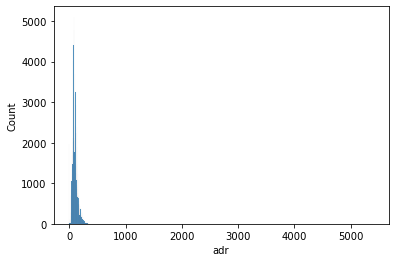

In [31]:
# dataset['adr'].value_counts()
sns.histplot(dataset['adr'])
# dataset.hist(column=['adr'], bins=10, low=0, high=1000)

In [32]:
# transforming the adr using standard scalar approach
dataset['adr'] = (dataset['adr'] - dataset['adr'].mean())/dataset['adr'].std()

In [33]:
dataset['adr']

0        -2.015123
1        -2.015123
2        -0.530993
3        -0.530993
4        -0.075860
            ...   
119385   -0.112666
119386    2.445776
119387    1.105706
119388    0.050786
119389    0.976883
Name: adr, Length: 119386, dtype: float64

In [34]:
dataset['required_car_parking_spaces'].value_counts()

0    111970
1      7383
2        28
3         3
8         2
Name: required_car_parking_spaces, dtype: int64

In [35]:
# converting required_car_parking_spaces to yes/no
def map_car_parking(x):
    if (x==0):
        return False
    else:
        return True
dataset['required_car_parking'] = dataset['required_car_parking_spaces'].map(map_car_parking)
dataset = dataset.drop(['required_car_parking_spaces'], axis=1)

In [36]:
dataset['required_car_parking'].value_counts()

False    111970
True       7416
Name: required_car_parking, dtype: int64

In [37]:
dataset['total_of_special_requests'].value_counts()

0    70318
1    33223
2    12968
3     2497
4      340
5       40
Name: total_of_special_requests, dtype: int64

In [38]:
# special requests made or not. 
def map_special_requests(x):
    if (x==0):
        return False
    else:
        return True
dataset['special_requests_made'] = dataset['total_of_special_requests'].map(map_special_requests)
dataset = dataset.drop(['total_of_special_requests'], axis=1)

<AxesSubplot:xlabel='lead_time', ylabel='Count'>

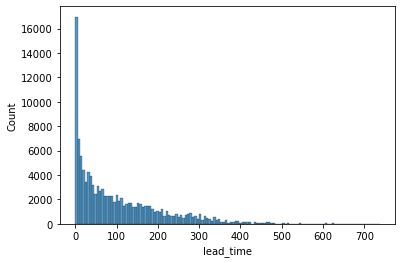

In [39]:
# converting continuous lead time to categorical lead time. 
sns.histplot(dataset['lead_time'])

In [40]:
def map_lead_time(x):
    if (x==0):
        return "none"
    elif (x>0 and x<=30):
        return "1month"
    elif (x>30 and x<=90):
        return "1-3months"
    elif (x>90 and x<180):
        return '3-6months'
    elif (x>180):
        return 'more_than_6months'
dataset['lead_time'] = dataset['lead_time'].map(map_lead_time)

In [41]:
# keeping this as it is
dataset['total_stay']

0         0
1         0
2         1
3         1
4         2
         ..
119385    7
119386    7
119387    7
119388    7
119389    9
Name: total_stay, Length: 119386, dtype: int64

In [42]:
# keeping this as it is
dataset['guests']

0         2.0
1         2.0
2         1.0
3         1.0
4         2.0
         ... 
119385    2.0
119386    3.0
119387    2.0
119388    2.0
119389    2.0
Name: guests, Length: 119386, dtype: float64

In [43]:
# keeping this as it is
dataset['different_room_assigned']

0         False
1         False
2          True
3         False
4         False
          ...  
119385    False
119386    False
119387    False
119388    False
119389    False
Name: different_room_assigned, Length: 119386, dtype: bool

In [44]:
# encoding categorical features using one hot encoding. 
# so that causalnex and other algorithms can work on the numeric data. 
le = LabelEncoder()
non_numeric_columns = ['lead_time','previous_cancellations', 'booking_changes', 'days_in_waiting_list',
                       'arrival_season','previous_bookings_retention']
for col in non_numeric_columns:
    dataset[col] = le.fit_transform(dataset[col])

In [45]:
dataset.head()

,is_canceled,lead_time,is_repeated_guest,previous_cancellations,booking_changes,deposit,days_in_waiting_list,adr,total_stay,guests,different_room_assigned,arrival_season,previous_bookings_retention,required_car_parking,special_requests_made
0,False,3,0,1,2,False,3,-2.015123,0,2.0,False,2,1,False,False
1,False,3,0,1,2,False,3,-2.015123,0,2.0,False,2,1,False,False
2,False,1,0,1,3,False,3,-0.530993,1,1.0,True,2,1,False,False
3,False,1,0,1,3,False,3,-0.530993,1,1.0,False,2,1,False,False
4,False,1,0,1,3,False,3,-0.075860,2,2.0,False,2,1,False,True


# Causal discovery: Infering causal structure from data

We will use following algorithms to create the causal graph:
* notears
* PC(peter-clerk) algo
* GES algo
* do-why 

In [46]:
struct_data = dataset.copy(deep=True)

In [47]:
struct_data

,is_canceled,lead_time,is_repeated_guest,previous_cancellations,booking_changes,deposit,days_in_waiting_list,adr,total_stay,guests,different_room_assigned,arrival_season,previous_bookings_retention,required_car_parking,special_requests_made
0,False,3,0,1,2,False,3,-2.015123,0,2.0,False,2,1,False,False
1,False,3,0,1,2,False,3,-2.015123,0,2.0,False,2,1,False,False
2,False,1,0,1,3,False,3,-0.530993,1,1.0,True,2,1,False,False
3,False,1,0,1,3,False,3,-0.530993,1,1.0,False,2,1,False,False
4,False,1,0,1,3,False,3,-0.075860,2,2.0,False,2,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,False,1,0,1,3,False,3,-0.112666,7,2.0,False,2,1,False,False
119386,False,2,0,1,3,False,3,2.445776,7,3.0,False,2,1,False,True
119387,False,0,0,1,3,False,3,1.105706,7,2.0,False,2,1,False,True
119388,False,2,0,1,3,False,3,0.050786,7,2.0,False,2,1,False,False


In [48]:
# converting boolean features to numeric for the notears algo to use. 
struct_data['is_canceled'] = struct_data['is_canceled'].astype(int)
struct_data['deposit'] = struct_data['deposit'].astype(int)
struct_data['different_room_assigned'] = struct_data['different_room_assigned'].astype(int)
struct_data['required_car_parking'] = struct_data['required_car_parking'].astype(int)
struct_data['special_requests_made'] = struct_data['special_requests_made'].astype(int)

In [49]:
struct_data['days_in_waiting_list'].value_counts()

3    115688
0      2138
2       968
1       592
Name: days_in_waiting_list, dtype: int64

In [50]:
sm = from_pandas(struct_data)
sm.remove_edges_below_threshold(0.8)

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


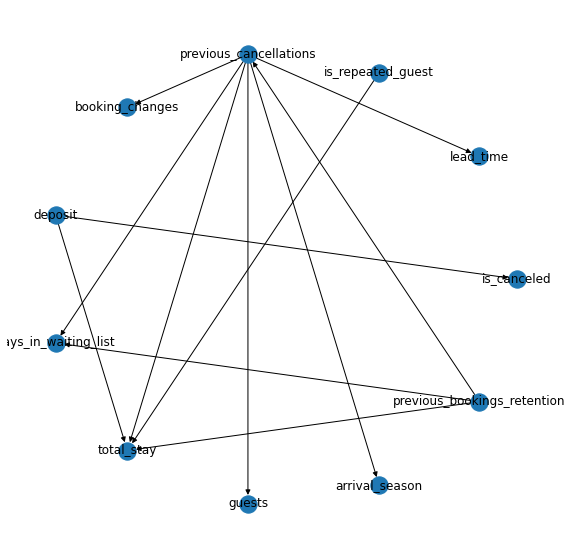

In [51]:
sm_largest = sm.get_largest_subgraph()
fig, ax = plt.subplots(figsize=(10,10))
nx.draw_circular(sm_largest, ax=ax, with_labels=True)
fig.show()

In [52]:
#creating bayesian network
bn = BayesianNetwork(sm_largest)

BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.


## causal graph using PC algo, GIES algo with cdt library

Following shows the cdt libray with PC, GES, GIES algorithms and the causal graphs created by them. 

<h2>Glasso</h2>
<p>Graphical Lasso to find an adjacency matrix</p>

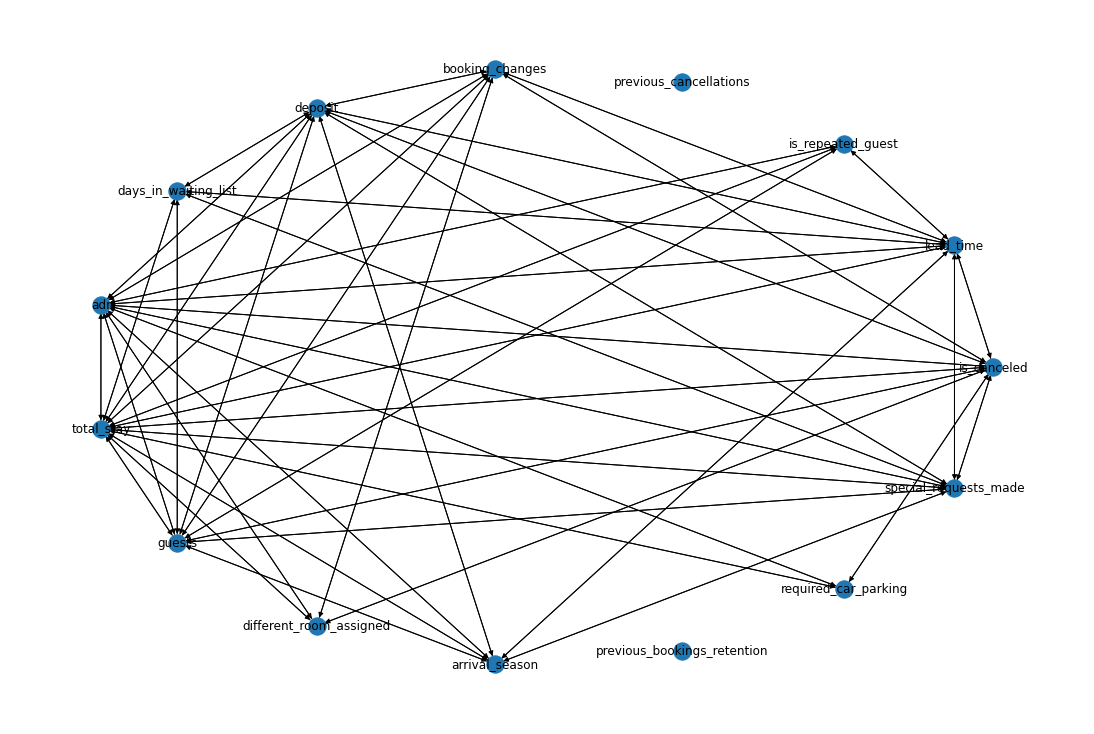

In [53]:
glasso = cdt.independence.graph.Glasso()
skeleton = glasso.predict(struct_data)
# visualize network
fig=plt.figure(figsize=(15,10))
#nx.draw_networkx(skeleton, font_size=18, font_color='r')
pos = nx.draw_circular(skeleton, with_labels = True)
nx.draw(skeleton, pos = pos,ax=ax, with_labels=True,node_size = 600, font_size = 20)

In [54]:
cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.2.2/bin/Rscript'

<h2>PC Algorithm</h2>

PC is ran on the skeleton of the given graph.


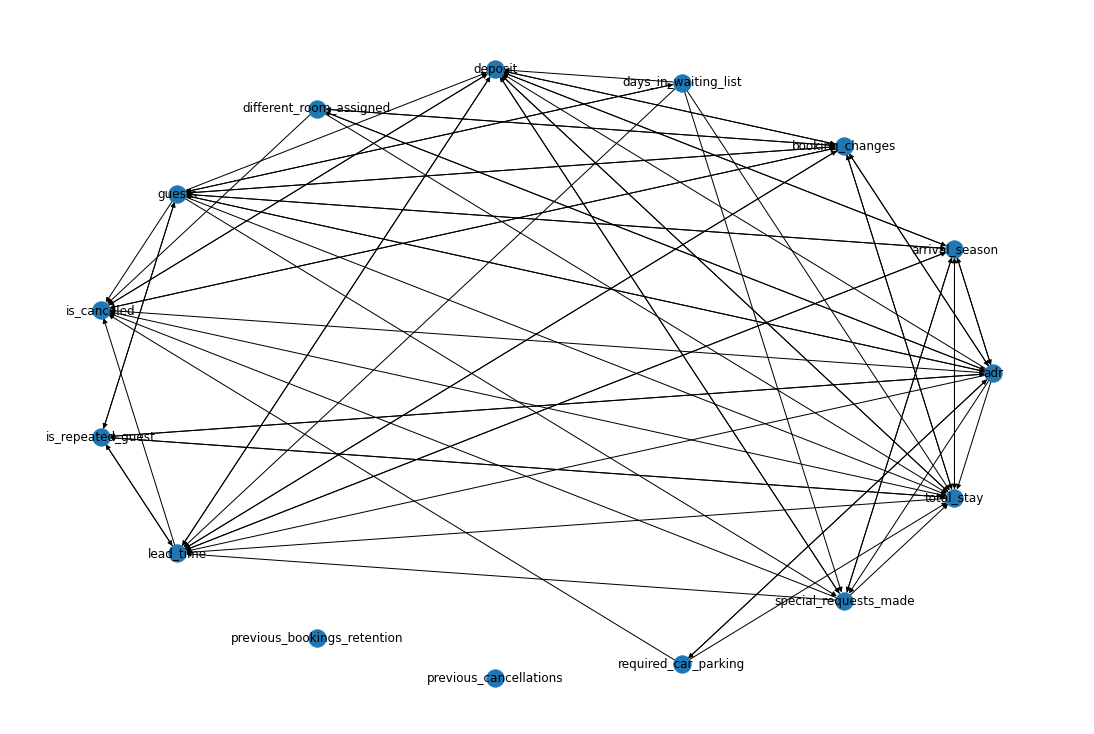

In [55]:
model_pc = cdt.causality.graph.PC(alpha='0.9')
graph_pc = model_pc.predict(struct_data, skeleton)
#orient_undirected_graph = cdt.causality.graph.PC.orient_undirected_graph(,data=struct_data,graph=graph_pc)

fig=plt.figure(figsize=(15,10))
#nx.draw_networkx(graph_pc, font_size=18, font_color='r')
pos = nx.draw_circular(graph_pc, with_labels = True)
nx.draw(graph_pc, pos = pos,ax=ax, with_labels=True,node_size = 600, font_size = 20)
a_graph = nx.nx_agraph.to_agraph(graph_pc)
d_graph = graph_pc.to_directed()
#pos = nx.draw_circular(d_graph, with_labels = True)
#nx.draw(d_graph, pos = pos,ax=ax, with_labels=True,node_size = 600, font_size = 20)
#print(nx.is_directed_acyclic_graph(d_graph))
#print(a_graph)

<h1>GES</h1>
<p> Greedy Search Algo (score-based)<p>

GES is ran on the skeleton of the given graph.


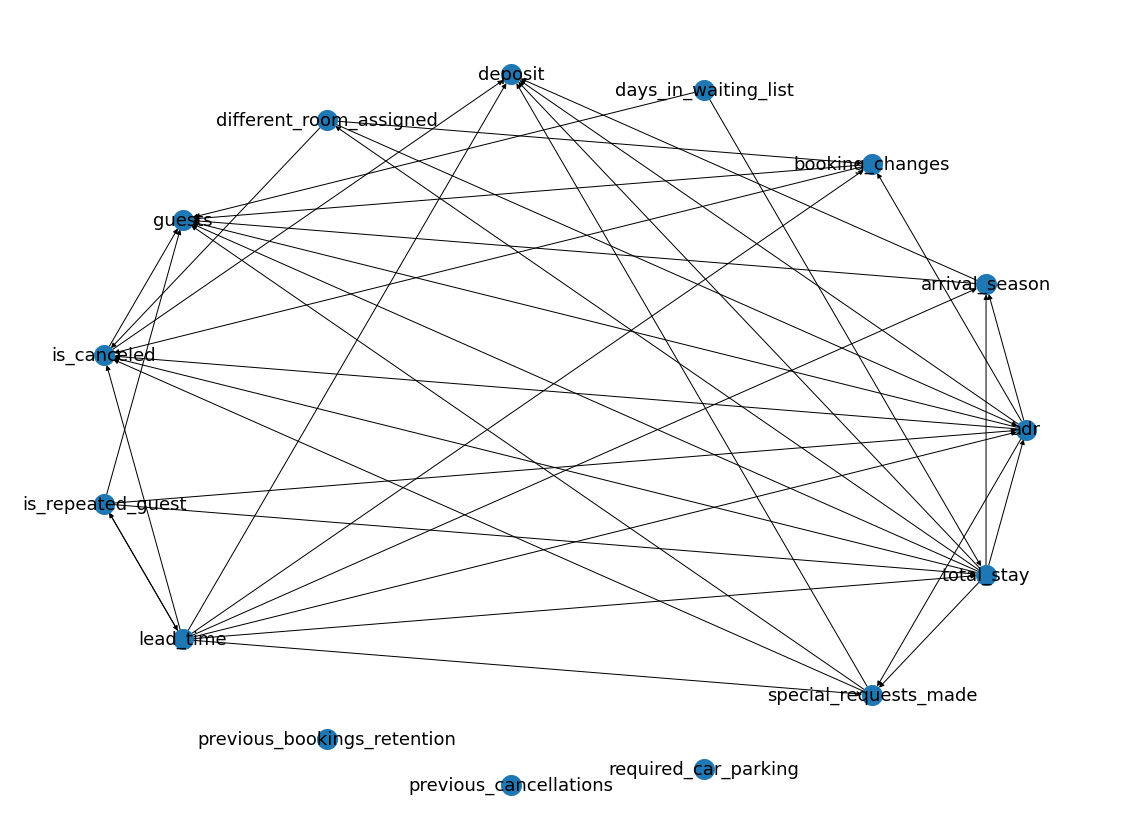

In [56]:
model_ges = cdt.causality.graph.GES()
graph_ges = model_ges.predict(struct_data, skeleton)

fig, ax = plt.subplots(figsize=(20,15))
#fig=plt.figure(figsize=(20,15))
#nx.draw_networkx(graph_ges, font_size=18, font_color='r' , arrows = True,node_size = 200)
nx.draw_circular(graph_ges, ax=ax, with_labels=True,node_size = 400, font_size = 18)
# get adjaceny matrix of GES graph
A_ges = nx.adjacency_matrix(graph_ges).todense()

<h2>GIES</h2>
<p>Score Based algorithm</p>

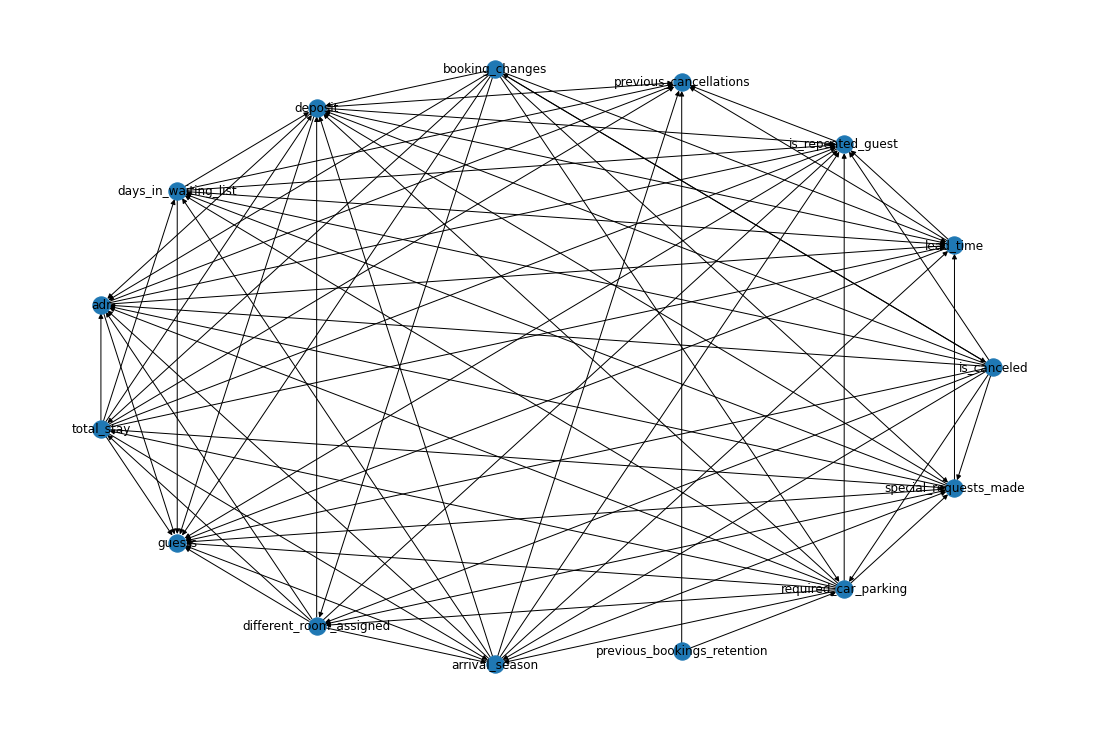

In [57]:
model_GIES = cdt.causality.graph.GIES()
graph_GIES = model_GIES.predict(struct_data)

fig=plt.figure(figsize=(15,10))
#nx.draw_networkx(graph_CCDr, font_size=18, font_color='r')
pos = nx.draw_circular(graph_GIES, with_labels = True)
nx.draw(graph_GIES, pos = pos,ax=ax, with_labels=True,node_size = 600, font_size = 20)

A_CCDr = nx.adjacency_matrix(graph_GIES).todense()

<h2>CCDr</h2>
<ul>
    <li>Concave penalized Coordinate Descent with reparametrization)</li>
    <li>score based method for learning Bayesian networks that uses sparse regularization and block-cyclic coordinate descent.</li>
</ul>

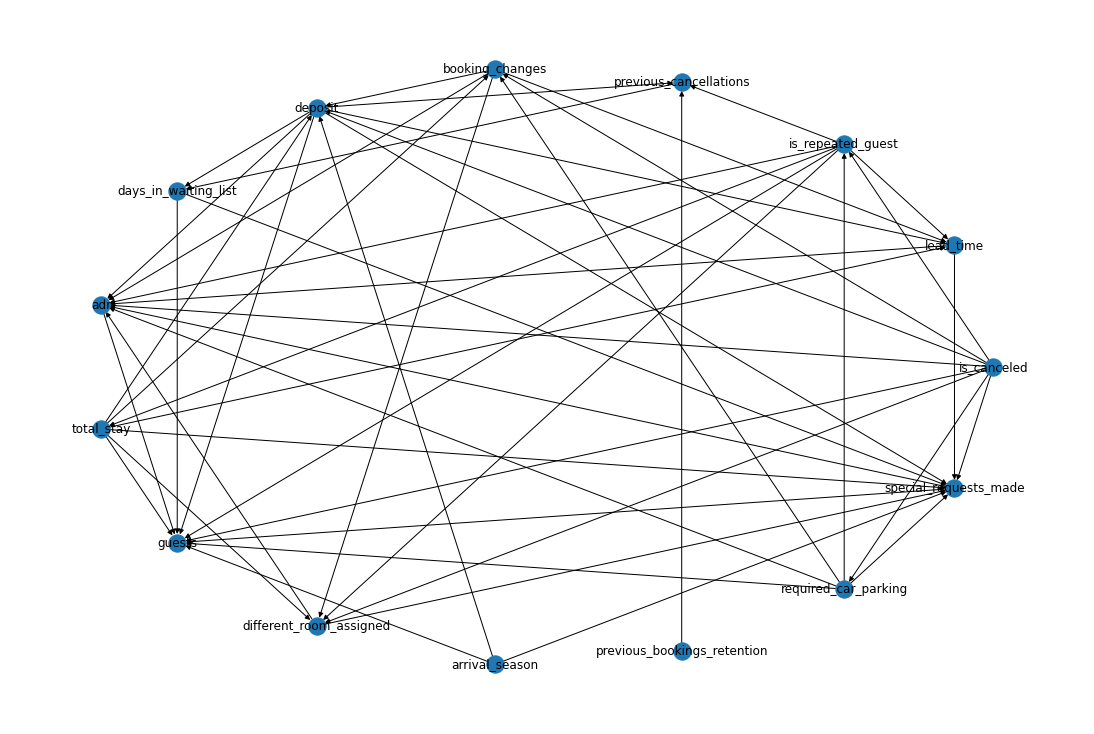

In [58]:
model_CCDr = cdt.causality.graph.CCDr()
graph_CCDr = model_CCDr.predict(struct_data)

fig=plt.figure(figsize=(15,10))
#nx.draw_networkx(graph_CCDr, font_size=18, font_color='r')
pos = nx.draw_circular(graph_CCDr, with_labels = True)
nx.draw(graph_CCDr, pos = pos,ax=ax, with_labels=True,node_size = 600, font_size = 20)

A_CCDr = nx.adjacency_matrix(graph_CCDr).todense()

<h2>LiNGAM</h2>
<p>Exploiting Assymetry</p>

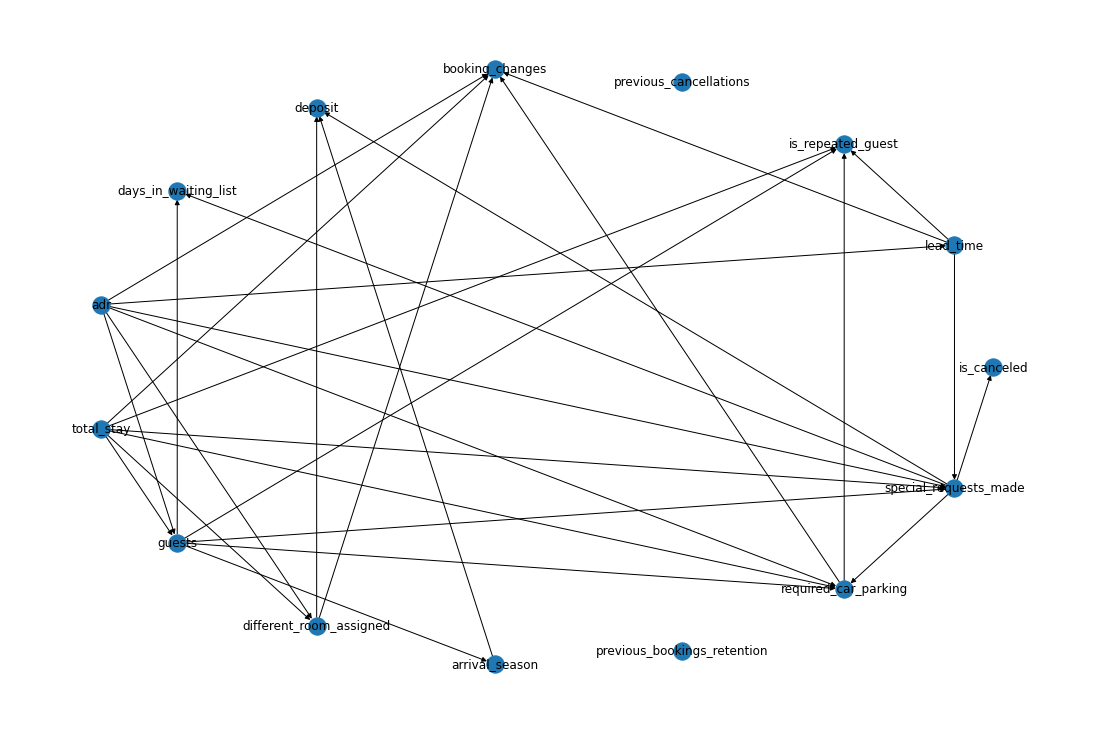

In [59]:
model_lingam = cdt.causality.graph.LiNGAM()
graph_lingam = model_lingam.predict(struct_data)

fig=plt.figure(figsize=(15,10))
#nx.draw_networkx(graph_lingam, font_size=18, font_color='r')
pos = nx.draw_circular(graph_lingam, with_labels = True)
nx.draw(graph_lingam, pos = pos,ax=ax, with_labels=True,node_size = 600, font_size = 20)

A_lingam = nx.adjacency_matrix(graph_lingam).todense()

<h2>Dowhy</h2>
<p> Creation of the model based on the graph obtained through notears algorithm</p>

In [60]:
#create the dot graph given by the notears algorithm
dot_graph = graphviz.Digraph()

#add attributes to the graph
dot_graph.graph_attr['rankdir'] = 'LR'

#add nodes to the graph
dot_graph.node('U', 'Unobserved Confounders')
dot_graph.node('is_repeated_guest', 'Repeated Guest')
dot_graph.node('lead_time', 'Lead Time')
dot_graph.node('is_canceled', 'Is Canceled')
dot_graph.node('previous_bookings_retention', 'Previous Bookings Retention')
dot_graph.node('total_stay', 'Total Stay')
dot_graph.node('days_in_waiting_list', 'Days in Waiting List')
dot_graph.node('deposit', 'Deposit')
dot_graph.node('previous_cancellations', 'Previous Cancellations')

#add edges to the graph
dot_graph.edge('U','lead_time')
dot_graph.edge('U','is_canceled')
dot_graph.edge('is_repeated_guest', 'total_stay')
dot_graph.edge('lead_time', 'days_in_waiting_list')
dot_graph.edge('previous_bookings_retention', 'previous_cancellations')
dot_graph.edge('previous_bookings_retention', 'total_stay')
dot_graph.edge('days_in_waiting_list', 'is_canceled')
dot_graph.edge('deposit', 'is_canceled')
dot_graph.edge('deposit', 'total_stay')
dot_graph.edge('previous_cancellations', 'days_in_waiting_list')
dot_graph.edge('previous_cancellations', 'is_canceled')
dot_graph.edge('previous_cancellations', 'total_stay')
dot_graph.edge('previous_cancellations', 'lead_time')
dot_graph.edge('lead_time', 'is_canceled')
dot_graph.edge('deposit', 'lead_time')
dot_graph.edge('is_repeated_guest', 'is_canceled')

#display the graph
dot_graph.render('notears_graph', view=True)
dot_graph.save('notears_graph.dot')

'notears_graph.dot'

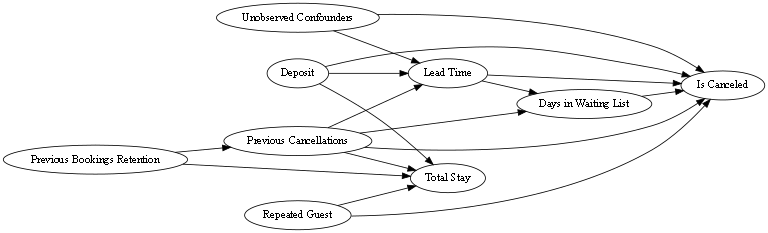

In [61]:
#create model for the dowhy (treatment -> deposit, outcome -> is_canceled)
model_deposit= dowhy.CausalModel(
        data = struct_data,
        graph='./notears_graph.dot',
        treatment='deposit',
        outcome='is_canceled')
model_deposit.view_model(layout='dot')
display(Image(filename="causal_model.png"))

In [62]:
#identification of the causal effects for the model (treatment -> deposit, outcome -> is_canceled)
identified_estimand_deposit = model_deposit.identify_effect(proceed_when_unidentifiable=True,method_name='exhaustive-search')
print(identified_estimand_deposit)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                               
──────────(Expectation(is_canceled))
d[deposit]                          
Estimand assumption 1, Unconfoundedness: If U→{deposit} and U→is_canceled then P(is_canceled|deposit,,U) = P(is_canceled|deposit,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [63]:
#model_deposit, estimation method --> backdoor linear regression

estimate_deposit_linear = model_deposit.estimate_effect(identified_estimand_deposit, 
                             method_name='backdoor.linear_regression',target_units="att")
print(estimate_deposit_linear)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                               
──────────(Expectation(is_canceled))
d[deposit]                          
Estimand assumption 1, Unconfoundedness: If U→{deposit} and U→is_canceled then P(is_canceled|deposit,,U) = P(is_canceled|deposit,)

## Realized estimand
b: is_canceled~deposit+deposit*is_repeated_guest+deposit*previous_bookings_retention+deposit*previous_cancellations
Target units: att

## Estimate
Mean value: 0.6986326127161264
### Conditional Estimates
__categorical__is_repeated_guest  __categorical__previous_bookings_retention  __categorical__previous_canc

In [64]:
#refutation of the deposit model using random_common_cause
refute1_results_deposit=model_deposit.refute_estimate(identified_estimand_deposit, estimate_deposit_linear,
        method_name="random_common_cause")
print(refute1_results_deposit)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'pr

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'pr

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'pr

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'pr

In [65]:
#refutation of the deposit model using placebo treatment
deposit_refute_placebo_treatment = model_deposit.refute_estimate(
                                    identified_estimand_deposit,
                                    estimate_deposit_linear,
                                    method_name="placebo_treatment_refuter",
                                    placebo_type="permute"
                                )
print(deposit_refute_placebo_treatment)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'pr

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'pr

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'pr

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'previous_bookings_retention', 'previous_cancellations', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'pr

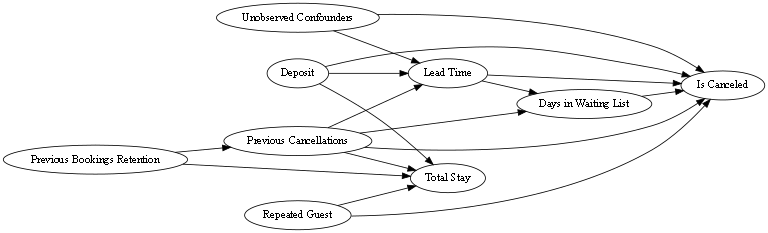

In [66]:
#create model for the dowhy (treatment -> prev_cancellations, outcome -> is_canceled)
model_prev_canc= dowhy.CausalModel(
        data = struct_data,
        graph='./notears_graph.dot',
        treatment='previous_cancellations',
        outcome='is_canceled')
model_prev_canc.view_model(layout='dot')
display(Image(filename="causal_model.png"))

In [67]:
#identification of the causal effects (treatment -> prev_cancellations, outcome -> is_canceled)
identified_estimand_prev_canc = model_prev_canc.identify_effect(proceed_when_unidentifiable=True,method_name='exhaustive-search')
print(identified_estimand_prev_canc)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                      
─────────────────────────(Expectation(is_canceled))
d[previous_cancellations]                          
Estimand assumption 1, Unconfoundedness: If U→{previous_cancellations} and U→is_canceled then P(is_canceled|previous_cancellations,,U) = P(is_canceled|previous_cancellations,)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(is_canceled, [previous_bookings_retention])*Derivative(
[previous_cancellations], [previous_bookings_retention])**(-1))
Estimand assumption 1, As-if-random: If U→→is_canceled then ¬(U →→{previous_bookings_retention})
Estimand assumption 2, Exclusion: If we remove {previous_bookings_retention}→{previous_cancellations}, then ¬({previous_bookings_retention}→is_canceled)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [68]:
#backdoor linear regression (treatment -> prev_cancellations, outcome -> is_canceled)
estimate_prev_canc_linear = model_prev_canc.estimate_effect(identified_estimand_prev_canc, 
                             method_name='backdoor.linear_regression',target_units="att")
print(estimate_prev_canc_linear)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                      
─────────────────────────(Expectation(is_canceled))
d[previous_cancellations]                          
Estimand assumption 1, Unconfoundedness: If U→{previous_cancellations} and U→is_canceled then P(is_canceled|previous_cancellations,,U) = P(is_canceled|previous_cancellations,)

## Realized estimand
b: is_canceled~previous_cancellations+previous_cancellations*is_repeated_guest+previous_cancellations*deposit
Target units: att

## Estimate
Mean value: -0.3380655235658742
### Conditional Estimates
__categorical__is_repeated_guest  __categorical__deposit
(-0.001, 1

In [69]:
#refute of the previous_cancellations model using random_common_cause
refute1_results_prev_canc=model_prev_canc.refute_estimate(identified_estimand_prev_canc, estimate_prev_canc_linear,
        method_name="random_common_cause")
print(refute1_results_prev_canc)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_interv

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_interv

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_interv

In [70]:
#refute of previous_cancellation model using placebo_treatment
prev_canc_refute_placebo_treatment = model_prev_canc.refute_estimate(
                                    identified_estimand_prev_canc,
                                    estimate_prev_canc_linear,
                                    method_name="placebo_treatment_refuter",
                                    placebo_type="permute"
                                )
print(prev_canc_refute_placebo_treatment)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_interv

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_interv

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['is_repeated_guest', 'deposit', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_interv

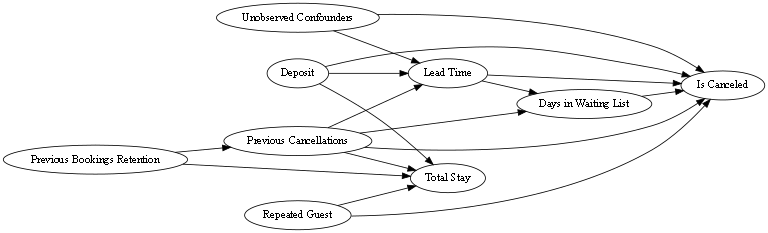

In [71]:
#create model for the dowhy (treatment -> is_repeated_guest, outcome -> is_canceled)
model_is_repeated= dowhy.CausalModel(
        data = struct_data,
        graph='./notears_graph.dot',
        treatment='is_repeated_guest',
        outcome='is_canceled')
model_is_repeated.view_model()
display(Image(filename="causal_model.png"))

In [72]:
#identify the effect for the model (treatment -> is_repeated_guest, outcome -> is_canceled)
identified_is_repeated = model_is_repeated.identify_effect(proceed_when_unidentifiable=True,method_name='exhaustive-search')
print(identified_is_repeated)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                    
────────────────────(Expectation(is_canceled))
d[is_repeated_guest]                          
Estimand assumption 1, Unconfoundedness: If U→{is_repeated_guest} and U→is_canceled then P(is_canceled|is_repeated_guest,,U) = P(is_canceled|is_repeated_guest,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [73]:
#estimation using backdoor.linear_regression
estimate_is_repeated_linear = model_is_repeated.estimate_effect(identified_is_repeated, 
                             method_name='backdoor.linear_regression',target_units="att")
print(estimate_is_repeated_linear)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                    
────────────────────(Expectation(is_canceled))
d[is_repeated_guest]                          
Estimand assumption 1, Unconfoundedness: If U→{is_repeated_guest} and U→is_canceled then P(is_canceled|is_repeated_guest,,U) = P(is_canceled|is_repeated_guest,)

## Realized estimand
b: is_canceled~is_repeated_guest+is_repeated_guest*lead_time+is_repeated_guest*deposit+is_repeated_guest*previous_bookings_retention+is_repeated_guest*days_in_waiting_list+is_repeated_guest*previous_cancellations
Target uni

In [74]:
#refute is_repeated_guest using random_common_cause
refute1_results_is_repeated=model_is_repeated.refute_estimate(identified_is_repeated, estimate_is_repeated_linear,
        method_name="random_common_cause")
print(refute1_results_is_repeated)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_interv

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_interv

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_interv

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_interv

In [75]:
#refute placebo_treatment model --> is_repeated_guest
is_repeated_refute_placebo_treatment = model_is_repeated.refute_estimate(
                                    identified_is_repeated,
                                    estimate_is_repeated_linear,
                                    method_name="placebo_treatment_refuter",
                                    placebo_type="permute"
                                )
print(is_repeated_refute_placebo_treatment)


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_interv

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_interv

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_interv

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['lead_time', 'deposit', 'previous_bookings_retention', 'U', 'days_in_waiting_list', 'previous_cancellations']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_interv